
Clustering Results:
Number of Clusters: 2
Best DB Index: 0.7341

Metrics for each cluster configuration:
   n_clusters  DB Index  Silhouette Score
0           2  0.734116          0.486852
1           3  0.766243          0.423514
2           4  0.800097          0.399082
3           5  0.857229          0.391503
4           6  0.809618          0.388025
5           7  0.852772          0.394321
6           8  0.865023          0.391013
7           9  0.842076          0.393742
8          10  0.854999          0.381428


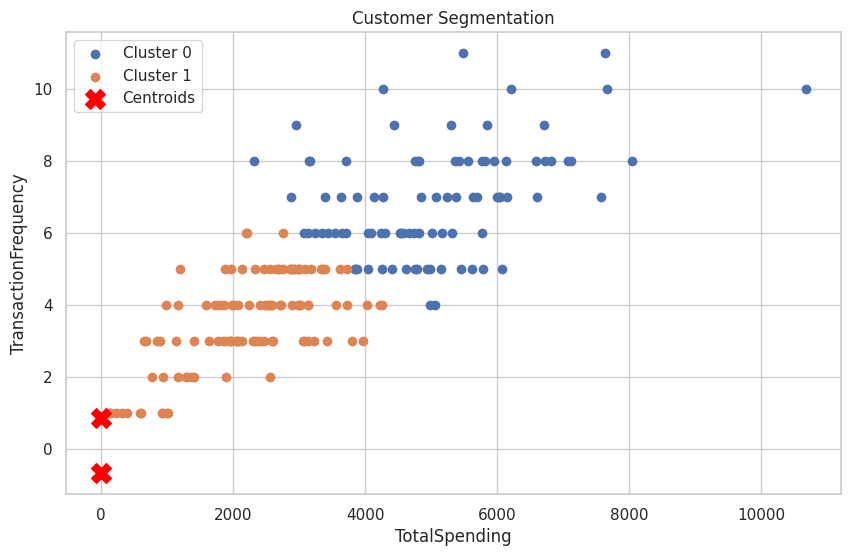

In [34]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(customer_path, product_path, transaction_path):
    customers = pd.read_csv(customer_path)
    products = pd.read_csv(product_path)
    transactions = pd.read_csv(transaction_path)
    return customers, products, transactions

def preprocess_data(customers, products, transactions):
    customers.drop_duplicates(inplace=True)
    products.drop_duplicates(inplace=True)
    transactions.drop_duplicates(inplace=True)

    customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='left')
    customer_transactions = pd.merge(customer_transactions, products, on='ProductID', how='left')

    customer_transactions['TransactionAmount'] = customer_transactions['Quantity'] * customer_transactions['Price_y']
    customer_transactions['TotalSpending'] = customer_transactions.groupby('CustomerID')['TransactionAmount'].transform('sum')
    customer_transactions['TransactionFrequency'] = customer_transactions.groupby('CustomerID')['TransactionID'].transform('count')
    return customer_transactions

def prepare_features(customer_transactions):
    features = ['TotalSpending', 'TransactionFrequency']
    data = customer_transactions.groupby('CustomerID')[features].mean().reset_index()
    return data, features

def perform_clustering(data, features, n_clusters_range=(2, 10)):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[features])

    best_db_index = float('inf')
    best_n_clusters = 0
    results = []

    for n_clusters in range(n_clusters_range[0], n_clusters_range[1] + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(scaled_data)
        db_index = davies_bouldin_score(scaled_data, labels)
        silhouette_avg = silhouette_score(scaled_data, labels)

        results.append({'n_clusters': n_clusters, 'DB Index': db_index, 'Silhouette Score': silhouette_avg})

        if db_index < best_db_index:
            best_db_index = db_index
            best_n_clusters = n_clusters

    kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)
    data['Cluster'] = labels

    return data, kmeans, results, best_n_clusters, best_db_index

def visualize_clusters(data, features, kmeans):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    for cluster_id in range(kmeans.n_clusters):
        cluster_data = data[data['Cluster'] == cluster_id]
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]], label=f"Cluster {cluster_id}")

    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                s=200, c='red', marker='X', label='Centroids')

    plt.title("Customer Segmentation")
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.show()


customers, products, transactions = load_data(
    customer_path='/content/Customers.csv',
    product_path='/content/Products.csv',
    transaction_path='/content/Transactions.csv'
)

customer_transactions = preprocess_data(customers, products, transactions)


clustered_data, features = prepare_features(customer_transactions)

clustered_data, kmeans, results, best_n_clusters, best_db_index = perform_clustering(clustered_data, features)


print("\nClustering Results:")
print(f"Number of Clusters: {best_n_clusters}")
print(f"Best DB Index: {best_db_index:.4f}")
print("\nMetrics for each cluster configuration:")
results_df = pd.DataFrame(results)
print(results_df)

visualize_clusters(clustered_data, features, kmeans)
